In [2]:
%config IPCompleter.greedy=True

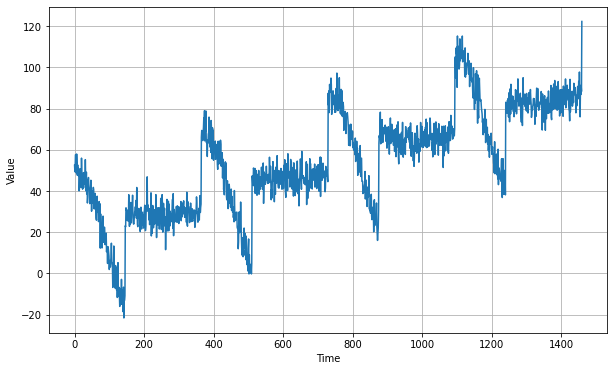

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time,series,format="-",start=0,end=None):
    plt.plot(time[start:end],series[start:end],format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    
def trend(time,slope=0):
    return slope*time

def seasonal_pattern(season_time):
    return np.where(season_time<0.4,np.cos(season_time*2*np.pi),1/np.exp(3*season_time))

def seasonality(time,period,amplitude=1,phase=0):
    season_time=((time+phase)%period)/period
    return amplitude*seasonal_pattern(season_time)

def noise(time,noise_level=1,seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time))*noise_level

time = np.arange(4*365+1,dtype="float32")
baseline = 10
series = trend(time,0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

series = baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)

series+= noise(time,noise_level,seed=42)

plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

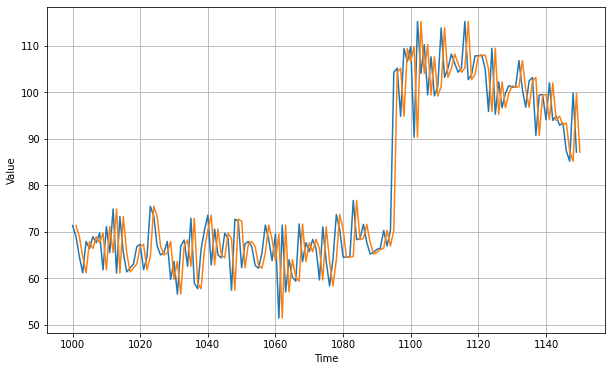

In [3]:
#朴素预测法
split_time=1000
time_train=time[:split_time]
x_train=series[:split_time]
time_valid=time[split_time:]
x_valid=series[split_time:]

naive_forecast = series[split_time-1:-1]

plt.figure(figsize=(10,6))
plot_series(time_valid,x_valid,start=0,end=150)
plot_series(time_valid,naive_forecast,start=1,end=151)

In [4]:
tf.compat.v1.enable_eager_execution()
print(keras.metrics.mean_squared_error(x_valid,naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid,naive_forecast).numpy())

61.827534
5.937908


1431
461


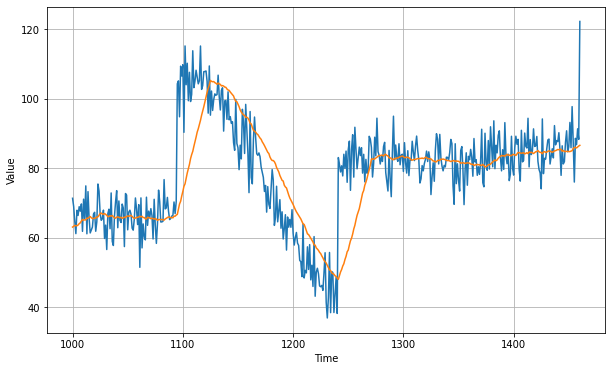

In [5]:
#移动平均法
def moving_average_forecast(series,window_size):
    forecast=[]
    for time in range(len(series)-window_size):
        forecast.append(series[time:time+window_size].mean())
    print(len(forecast))
    return np.array(forecast)


moving_avg=moving_average_forecast(series,30)[split_time-30:]      #后面的数组范围是限制返回值的数组范围
print(len(moving_avg))
plt.figure(figsize=(10,6))
plot_series(time_valid,x_valid)
plot_series(time_valid,moving_avg)


In [6]:
print(keras.metrics.mean_squared_error(x_valid,moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid,moving_avg).numpy())

106.674576
7.1424184


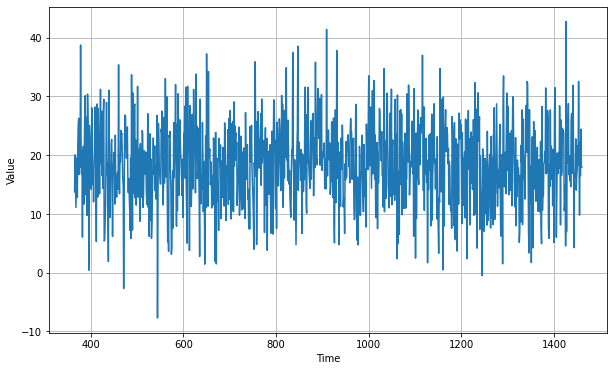

In [7]:
#去除趋势或周期性
diff_series =(series[365:]-series[:-365])
diff_time = time[365:]
plt.figure(figsize=(10,6))
plot_series(diff_time,diff_series)
plt.show()

1046


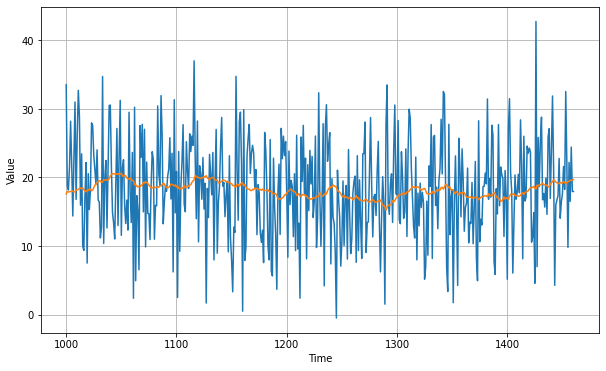

In [11]:
diff_moving_avg = moving_average_forecast(diff_series,50)[split_time - 365 -50:]    #对差异进行平均
plt.figure(figsize=(10,6))
plot_series(time_valid,diff_series[split_time-365:])
plot_series(time_valid,diff_moving_avg)
plt.show()

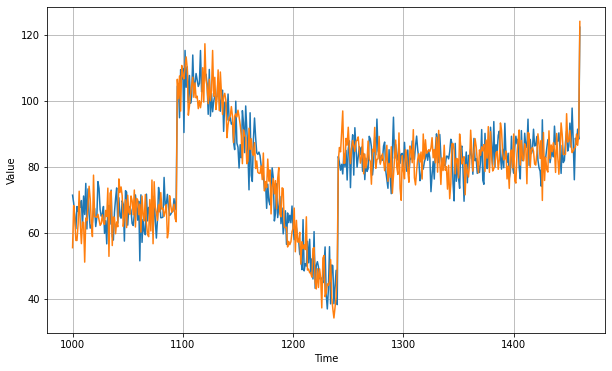

In [12]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg   #拿上一周期的数据加上平均过的波动差异
plt.figure(figsize=(10,6))
plot_series(time_valid,x_valid)
plot_series(time_valid,diff_moving_avg_plus_past)
plt.show()

In [13]:
print(keras.metrics.mean_squared_error(x_valid,diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid,diff_moving_avg_plus_past).numpy())

52.97366
5.839311


461


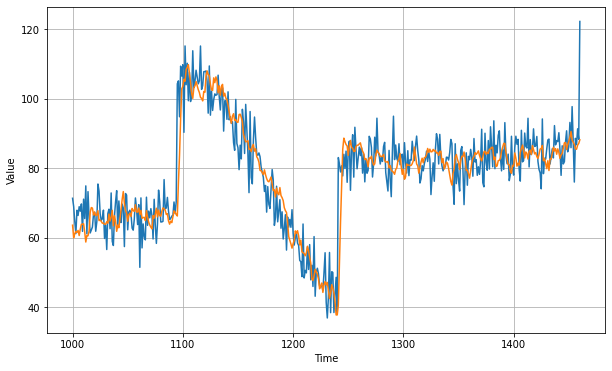

In [38]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 369:-365], 4) + diff_moving_avg    #平均上一周期+平均差异
plt.figure(figsize=(10,6))
plot_series(time_valid,x_valid)
plot_series(time_valid,diff_moving_avg_plus_smooth_past)
plt.show()

In [39]:
print(keras.metrics.mean_squared_error(x_valid,diff_moving_avg_plus_smooth_past ).numpy())
print(keras.metrics.mean_absolute_error(x_valid,diff_moving_avg_plus_smooth_past ).numpy())

45.953434
4.8969965
